In [93]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
import re
import zipfile
import os
import pandas as pd
from io import StringIO
import os
import re

In [94]:
def transpose_data(input_file):
    data = pd.read_csv(input_file)
    non_numeric_keys = [key for key in data.keys() if not (isinstance(key, (int, float)) or key.isdigit())]
    data = data.rename(columns={non_numeric_keys[0]: 'ID'})
    data = data.set_index('ID').transpose()
    return data

In [95]:
def unzip_and_process_files(zip_file_path, extract_to_folder, ignore_patterns=None):
    """Décompresse un fichier ZIP et applique la transposition sur les fichiers CSV."""
    
    # Vérifie si le fichier zip existe
    if not os.path.exists(zip_file_path):
        print(f"Le fichier zip {zip_file_path} n'existe pas.")
        return
    
    if  os.path.exists(extract_to_folder):
        print(f"Le fichier est déjà décompressé dans {extract_to_folder}.")
        return
    
    # Crée le dossier de destination si il n'existe pas
    os.makedirs(extract_to_folder, exist_ok=True)

    # Liste des fichiers à ignorer
    if ignore_patterns is None:
        ignore_patterns = []

    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            # Liste tous les fichiers du zip
            zip_files = zip_ref.namelist()

            # Extraire uniquement les fichiers qui ne sont pas dans les fichiers à ignorer
            for file_name in zip_files:
                # Si le fichier correspond à un des patterns à ignorer, on l'ignore
                if any(pattern in file_name for pattern in ignore_patterns):
                    continue  # Ignore ce fichier et passe au suivant
                
                # Si le fichier est un CSV, on applique la transposition
                if file_name.endswith('.csv'):
                    zip_ref.extract(file_name, extract_to_folder)
                    # Appliquer la transposition
                    file_path = os.path.join(extract_to_folder, file_name)
                    transposed_data = transpose_data(file_path)
                    transposed_data.to_csv(file_path,index=False)
                    print(f"Fichier transposé et extrait : {file_path}")
            
            print(f"Extraction terminée dans {extract_to_folder}")
    
    except zipfile.BadZipFile:
        print(f"Erreur : Le fichier {zip_file_path} n'est pas un fichier zip valide.")
    except Exception as e:
        print(f"Erreur lors de la décompression : {e}")

In [96]:
def get_files_paths(directory_path):
    files_paths = []  # Liste pour stocker les fichiers trouvés
    
    # Parcourir les fichiers dans le répertoire
    for root, dir,files in os.walk(directory_path):
        for file_name in files:
            # Ajouter le chemin complet du fichier à la liste
            files_paths.append(os.path.join(root, file_name))

    return files_paths

In [97]:
def extract_number_from_path(path):
    # Utiliser une expression régulière pour extraire le premier nombre dans le chemin
    match = re.search(r'\\(\d+)', path)
    if match:
        return int(match.group(1))  # Retourner le nombre comme un entier
    return 0  # Par défaut, retourner 0 si pas de nombre trouvé

In [98]:
def estimate_sampling_rate_from_duration(file_path, duration_seconds):
    data = pd.read_csv(file_path)
    num_samples = data.shape[0]
    sampling_rate = round(num_samples / duration_seconds / 10) * 10
    return round(sampling_rate)

In [99]:
def get_exercice_type(files_paths):
    exercice_type = set()
    for file_path in files_paths:
        patient_number = file_path.split('\\')[1]
        if patient_number != '1':
            break 
        exercice_name = file_path.split('\\')[2]
        exercice_type.add(exercice_name)
    return exercice_type

In [100]:
def get_sensors_type_and_sampling_rate(files_paths):
    SENSORS_TYPE = {}
    DURATION = 66.1

    for file_path in files_paths:
        patient_number = file_path.split('\\')[1]
        
        # Si le patient n'est pas '1', on ignore ce fichier
        if patient_number != '1':
            break
        
        # Récupérer le nom du capteur à partir du chemin du fichier
        sensor_name = file_path.split('\\')[3].split('_')[0].replace('.csv', '')
        
        # Estimer la fréquence d'échantillonnage
        sensor_rate = estimate_sampling_rate_from_duration(file_path, DURATION)
        
        # Vérifier si le capteur existe déjà dans le dictionnaire
        if sensor_name not in SENSORS_TYPE:
            # Si le capteur n'existe pas, on l'ajoute avec sa fréquence d'échantillonnage
            SENSORS_TYPE[sensor_name] = sensor_rate

    # Affichage du dictionnaire SENSORS_TYPE
    return SENSORS_TYPE

In [101]:
def get_number_of_patient(files_paths):
    # Utiliser un ensemble (set) pour garder les numéros de patient uniques
    patient_numbers = set()

    # Parcourir les chemins de fichiers
    for file_path in files_paths:
        # Extraire le numéro de patient (le second élément du chemin)
        patient_number = file_path.split('\\')[1]
        
        # Ajouter le numéro de patient à l'ensemble
        patient_numbers.add(patient_number)

    # Afficher le nombre de patients uniques
    return len(patient_numbers)

In [102]:
def count_files_in_directory(directory_path):
    return len([name for name in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, name))])

In [103]:
def resampling(dataset_wrong_frequency,dataset_desired_frequency,wrong_frequency,desired_frequency,debug=False):
    if wrong_frequency == desired_frequency:
        return dataset_wrong_frequency
    
    df_wrong_Hz = dataset_wrong_frequency
    sampling_rate_wrong_Hz = wrong_frequency
    df_wrong_Hz['time'] =  pd.date_range(start='00:00:00', periods=df_wrong_Hz.shape[0], freq=f'{int(1e6 / sampling_rate_wrong_Hz)}us')

    n_points_wrong_Hz = len(df_wrong_Hz)
    n_points_desired_Hz = dataset_desired_frequency.shape[0]

    time = pd.date_range(start=df_wrong_Hz['time'].iloc[0],periods=n_points_desired_Hz,freq=f'{int(desired_frequency/10)}ms')
    df_wrong_Hz.set_index('time', inplace=True)
    df_wrong_Hz_resampled = df_wrong_Hz.reindex(time).interpolate(method='linear')
    if debug == True:
        # Affichage des résultats
        print(f"Nombre de points à {wrong_frequency} Hz avant interpolation:", n_points_wrong_Hz)
        print(f"Nombre de points à {desired_frequency}  Hz après interpolation:", len(df_wrong_Hz_resampled))
    return df_wrong_Hz_resampled

In [104]:
def create_windows(data, window_size, step_size):
    """
    Crée des fenêtres glissantes à partir des données.
    :param data: array-like, données à segmenter
    :param window_size: int, taille de la fenêtre (en nombre d'échantillons)
    :param step_size: int, pas de la fenêtre (en nombre d'échantillons)
    :return: X (données segmentées), y (étiquettes correspondantes)
    """
    windows = []
    labels = []

    # Découper les données en fenêtres glissantes
    for start in range(0, len(data) - window_size, step_size):
        end = start + window_size
        window = data[start:end].drop('label', axis=1)  # Exclure la colonne 'label'
        windows.append(window[:-1])

        # L'étiquette correspond à la classe à partir du centre de la fenêtre
        # Cela suppose que l'étiquette correspond à la fenêtre entière
        labels.append(data.iloc[end - 1]['label'])  # Utiliser l'étiquette à la fin de la fenêtre
    
    # Convertir en arrays numpy pour Keras
    X = np.array(windows)  # Exclure la dernière fenêtre pour éviter les problèmes de dimensions
    y = np.array(labels)

    

    return X, y

In [105]:
zip_file_path = 'dataset.zip'
extract_to_folder = 'unprocessed_datasets' 
ignore_patterns = ['.txt', '_MACOSX','.DS_Store']

unzip_and_process_files(zip_file_path, extract_to_folder, ignore_patterns)

Le fichier est déjà décompressé dans unprocessed_datasets.


In [106]:
UNPROCESSED_FILES_PATH = sorted(get_files_paths('unprocessed_datasets'), key=extract_number_from_path)

SAMPLE_SIZE = get_number_of_patient(UNPROCESSED_FILES_PATH)

SENSORS_TYPE = get_sensors_type_and_sampling_rate(UNPROCESSED_FILES_PATH)

EXERCICES_TYPE = get_exercice_type(UNPROCESSED_FILES_PATH)

In [107]:
print(SENSORS_TYPE)

{'cop': 60, 'emg': 2000, 'imu': 100, 'ips': 60, 'mocap': 100}


In [108]:
print(EXERCICES_TYPE)

{'forward', 'halfsquat', 'back', 'still'}


In [109]:
for file_path in UNPROCESSED_FILES_PATH:
    if('_1' in file_path):
        pd.read_csv(file_path).to_csv(file_path.replace('_1',''),index=False)
        os.remove(file_path)
        print(file_path.replace('_1',''))

    if('_2' in file_path):
        data_1 = pd.read_csv(file_path.replace('_2',''))
        data_2 = pd.read_csv(file_path)
        pd.concat([data_1,data_2]).to_csv(file_path.replace('_2',''),index=False)
        os.remove(file_path)
        print(file_path.replace('_2',''))

    if('_3' in file_path):
        data_1 = pd.read_csv(file_path.replace('_3',''))
        data_2 = pd.read_csv(file_path)
        pd.concat([data_1,data_2]).to_csv(file_path.replace('_3',''),index=False)
        os.remove(file_path)
        print(file_path.replace('_3',''))
    

In [110]:
def remove_suffix_and_duplicates(file_names):
    """Supprime les suffixes '_x' et les doublons dans une liste de noms de fichiers."""
    cleaned_files = []
    seen = set()  # Utiliser un set pour suivre les fichiers déjà vus

    # Expression régulière pour capturer la partie avant '_x' (ou toute partie du nom)
    pattern = re.compile(r"(.*?)(_\d+)?\.[^\.]+$")  # Capte tout avant _x et l'extension

    for file in file_names:
        # Appliquer l'expression régulière pour retirer le suffixe _x
        match = pattern.match(file)
        if match:
            base_name = match.group(1)  # Nom sans le suffixe _x
            if base_name not in seen:
                cleaned_files.append(file.replace('_1',''))  # Ajouter le fichier original
                seen.add(base_name)  # Ajouter le nom de base pour éviter les doublons
        else:
            # Si l'expression régulière ne correspond pas, on ajoute le fichier tel quel
            cleaned_files.append(file.replace('_1',''))
            seen.add(file)  # Ajouter au set pour éviter les doublons

    return cleaned_files


In [111]:
UNPROCESSED_FILES_PATH = remove_suffix_and_duplicates(UNPROCESSED_FILES_PATH)

In [112]:
if not os.path.exists('processed_datasets'):
    os.makedirs('processed_datasets')

In [113]:
SENSORS_TYPE

{'cop': 60, 'emg': 2000, 'imu': 100, 'ips': 60, 'mocap': 100}

In [114]:
for file_path in UNPROCESSED_FILES_PATH:
    PROCESSED_FILES_PATH = os.path.dirname(file_path.replace('unprocessed_datasets','processed_datasets'))
    
    if not os.path.exists(PROCESSED_FILES_PATH):
        os.makedirs(PROCESSED_FILES_PATH)
    
    sensor_name = file_path.split('\\')[3].split('_')[0].replace('.csv','')
    sensor_rate = SENSORS_TYPE[sensor_name]
    
    if not os.path.exists(f'{PROCESSED_FILES_PATH}/{sensor_name}.csv'):
        processed_data = resampling(pd.read_csv(file_path),pd.read_csv('unprocessed_datasets\\1\\back\\cop.csv'),sensor_rate,60,debug=True)
        processed_data.to_csv(f'{PROCESSED_FILES_PATH}/{sensor_name}.csv',index=False)
        print(f'{PROCESSED_FILES_PATH}/{sensor_name}.csv est passé de {sensor_rate} Hz à 60Hz')

In [115]:
PROCESSED_FILES_PATH = sorted(get_files_paths('processed_datasets'), key=extract_number_from_path)

In [118]:
if not os.path.exists('normal_split'):
    os.makedirs('normal_split')

number_of_measures = pd.DataFrame(columns=list(EXERCICES_TYPE), index=list(SENSORS_TYPE.keys()))

for sensor in SENSORS_TYPE:
    df = pd.DataFrame()
    for exercice in EXERCICES_TYPE:
            #number_of_measures.loc[sensor,exercice] = df.shape[0]
            #df.to_csv(f'normal_split/{sensor}.csv',index=False)
            for i in range(1,SAMPLE_SIZE+1):
                try:
                    data = pd.read_csv(f'processed_datasets/{i}/{exercice}/{sensor}.csv')
                    data["label"] = exercice
                    df = pd.concat([df, data], axis=0).reset_index(drop=True)
                except:
                    continue
    if not os.path.exists(f'normal_split/{sensor}.csv'):
        df.to_csv(f'normal_split/{sensor}.csv',index=False)


In [119]:
for exercice in EXERCICES_TYPE:
    for sensor in SENSORS_TYPE:
        data = pd.read_csv(f"normal_split/{sensor}.csv")
        number_of_measures.loc[sensor,exercice] = data[data['label'] == exercice].shape[0]

In [120]:
number_of_measures

,forward,halfsquat,back,still
cop,78002,82864,97443,91683
emg,79460,91379,95352,99325
imu,79460,91379,95352,99325
ips,80198,88478,101859,91685
mocap,79460,88515,95352,99325


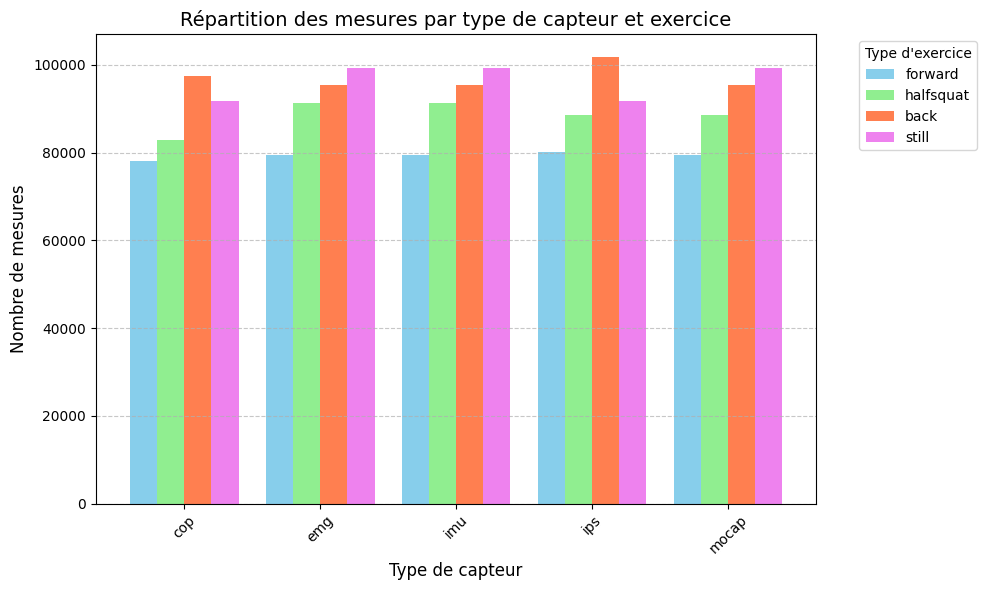

In [121]:
# Plot settings
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting grouped bars
number_of_measures.plot(kind='bar', ax=ax, width=0.8, color=['skyblue', 'lightgreen', 'coral', 'violet', 'gold'])

# Customize axes
ax.set_xlabel("Type de capteur", fontsize=12)
ax.set_ylabel("Nombre de mesures", fontsize=12)
ax.set_title("Répartition des mesures par type de capteur et exercice", fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.tick_params(axis='x', rotation=45)

# Add legend
ax.legend(title="Type d'exercice", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [122]:
NORMAL_SPLIT_FILES_PATH = sorted(get_files_paths('normal_split'), key=extract_number_from_path)

In [136]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

sampling_strategy = {}
for exercice in EXERCICES_TYPE:
    sampling_strategy[exercice] = 100000  # Nombre cible d'échantillons pour chaque classe

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

for file_path in NORMAL_SPLIT_FILES_PATH:
    df = pd.read_csv(file_path)

    df.dropna(inplace=True)
    # Séparation des caractéristiques et des labels
    X = df.drop(columns=['label'])  # Caractéristiques
    y = df['label']  # Labels
    
    # Vérification de la distribution des classes actuelles
    current_class_counts = y.value_counts()

    if(X.shape[0] != 400000):
        
        print(f"Before SMOTE or Under-Sampling to {file_path}")
        print(X.shape, y.shape)
        # Appliquer un RandomUnderSampler uniquement si une classe a plus d'échantillons que la cible
        if any(current_class_counts[exercice] > 100000 for exercice in EXERCICES_TYPE):
            print("Applying Random Under-Sampling due to over-represented classes")
            # Sous-échantillonnage : ne réduire qu'à la taille cible (pas plus)
            undersample_strategy = {exercice: min(current_class_counts[exercice], 100000) for exercice in EXERCICES_TYPE}
            under_sampler = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
            X_resampled, y_resampled = under_sampler.fit_resample(X, y)
        else:
            # Appliquer SMOTE pour équilibrer les classes (ajouter des échantillons)
            X_resampled, y_resampled = smote.fit_resample(X, y)

        print(f"After SMOTE or Under-Sampling to {file_path}")
        print(X_resampled.shape, y_resampled.shape)

        # Combinaison des caractéristiques et des labels dans un nouveau DataFrame
        """ balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
            balanced_df['label'] = y_resampled"""

        balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                        pd.DataFrame({'label': y_resampled}), ], axis=1)

        # Sauvegarder le DataFrame rééchantillonné dans un nouveau fichier CSV
        balanced_df.to_csv(file_path, index=False)
    else:
        print(f"Already balanced {file_path}")

Already balanced normal_split\cop.csv
Already balanced normal_split\emg.csv
Already balanced normal_split\imu.csv
Before SMOTE or Under-Sampling to normal_split\ips.csv
(360361, 682) (360361,)
After SMOTE or Under-Sampling to normal_split\ips.csv
(400000, 682) (400000,)
Already balanced normal_split\mocap.csv


In [137]:
for file_path in NORMAL_SPLIT_FILES_PATH:
    df = pd.read_csv(file_path)

    df.dropna(inplace=True)
    # Séparation des caractéristiques et des labels
    X = df.drop(columns=['label'])  # Caractéristiques
    y = df['label']  # Labels
    
    # Vérification de la distribution des classes actuelles
    current_class_counts = y.value_counts()

    if(X.shape[0] != 400000):
        
        print(f"Before SMOTE or Under-Sampling to {file_path}")
        print(X.shape, y.shape)
        # Appliquer un RandomUnderSampler uniquement si une classe a plus d'échantillons que la cible
        if any(current_class_counts[exercice] > 100000 for exercice in EXERCICES_TYPE):
            print("Applying Random Under-Sampling due to over-represented classes")
            # Sous-échantillonnage : ne réduire qu'à la taille cible (pas plus)
            undersample_strategy = {exercice: min(current_class_counts[exercice], 100000) for exercice in EXERCICES_TYPE}
            under_sampler = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
            X_resampled, y_resampled = under_sampler.fit_resample(X, y)
        else:
            # Appliquer SMOTE pour équilibrer les classes (ajouter des échantillons)
            X_resampled, y_resampled = smote.fit_resample(X, y)

        print(f"After SMOTE or Under-Sampling to {file_path}")
        print(X_resampled.shape, y_resampled.shape)

        # Combinaison des caractéristiques et des labels dans un nouveau DataFrame
        """ balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
            balanced_df['label'] = y_resampled"""

        balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                        pd.DataFrame({'label': y_resampled}), ], axis=1)

        # Sauvegarder le DataFrame rééchantillonné dans un nouveau fichier CSV
        balanced_df.to_csv(file_path, index=False)
    else:
        print(f"Already balanced {file_path}")

Already balanced normal_split\cop.csv
Already balanced normal_split\emg.csv
Already balanced normal_split\imu.csv
Already balanced normal_split\ips.csv
Already balanced normal_split\mocap.csv


In [138]:
for exercice in EXERCICES_TYPE:
    for sensor in SENSORS_TYPE:
        data = pd.read_csv(f"normal_split/{sensor}.csv")
        number_of_measures.loc[sensor,exercice] = data[data['label'] == exercice].shape[0]

In [139]:
number_of_measures

,forward,halfsquat,back,still
cop,100000,100000,100000,100000
emg,100000,100000,100000,100000
imu,100000,100000,100000,100000
ips,100000,100000,100000,100000
mocap,100000,100000,100000,100000


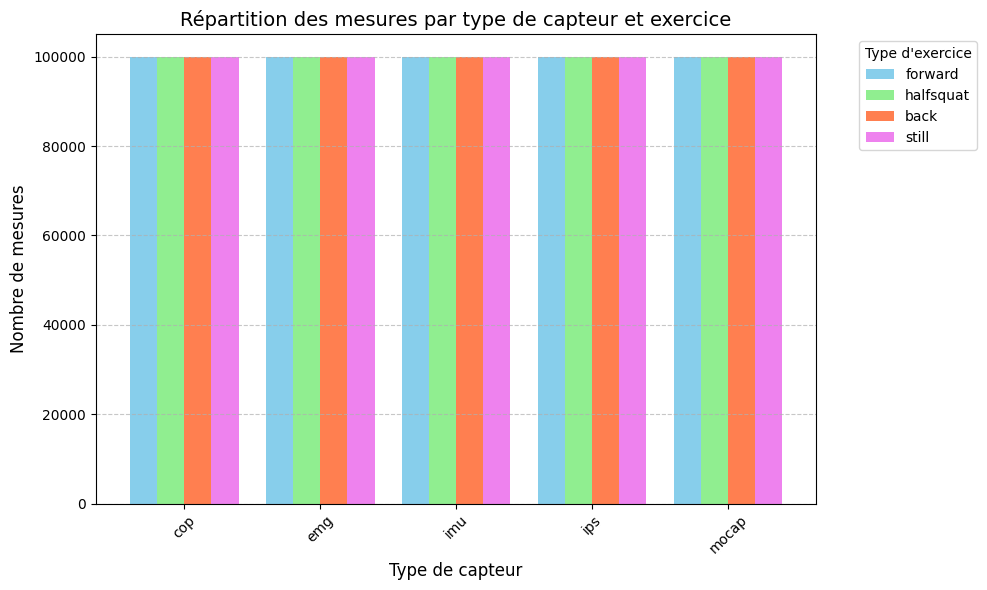

In [140]:
# Plot settings
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting grouped bars
number_of_measures.plot(kind='bar', ax=ax, width=0.8, color=['skyblue', 'lightgreen', 'coral', 'violet', 'gold'])

# Customize axes
ax.set_xlabel("Type de capteur", fontsize=12)
ax.set_ylabel("Nombre de mesures", fontsize=12)
ax.set_title("Répartition des mesures par type de capteur et exercice", fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.tick_params(axis='x', rotation=45)

# Add legend
ax.legend(title="Type d'exercice", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [141]:
if not os.path.exists('logo_split'):
    os.makedirs('logo_split')

number_of_measures = pd.DataFrame(columns=list(EXERCICES_TYPE), index=list(SENSORS_TYPE.keys()))

for sensor in SENSORS_TYPE:
    df = pd.DataFrame()
    for exercice in EXERCICES_TYPE:
            for i in range(1,SAMPLE_SIZE+1):
                try:
                    data = pd.read_csv(f'processed_datasets/{i}/{exercice}/{sensor}.csv')
                    data["label"] = exercice
                    data["patient"] = i 
                    df = pd.concat([df, data], axis=0).reset_index(drop=True)
                except:
                    continue
    if not os.path.exists(f'logo_split/{sensor}.csv'):
        print(f'logo_split/{sensor}.csv')
        df.to_csv(f'logo_split/{sensor}.csv',index=False)


In [142]:
for exercice in EXERCICES_TYPE:
    for sensor in SENSORS_TYPE:
        data = pd.read_csv(f"logo_split/{sensor}.csv")
        number_of_measures.loc[sensor,exercice] = data[data['label'] == exercice].shape[0]
        
number_of_measures

,forward,halfsquat,back,still
cop,100000,100000,100000,100000
emg,100000,100000,100000,100000
imu,100000,100000,100000,100000
ips,100000,100000,100000,100000
mocap,100000,100000,100000,100000


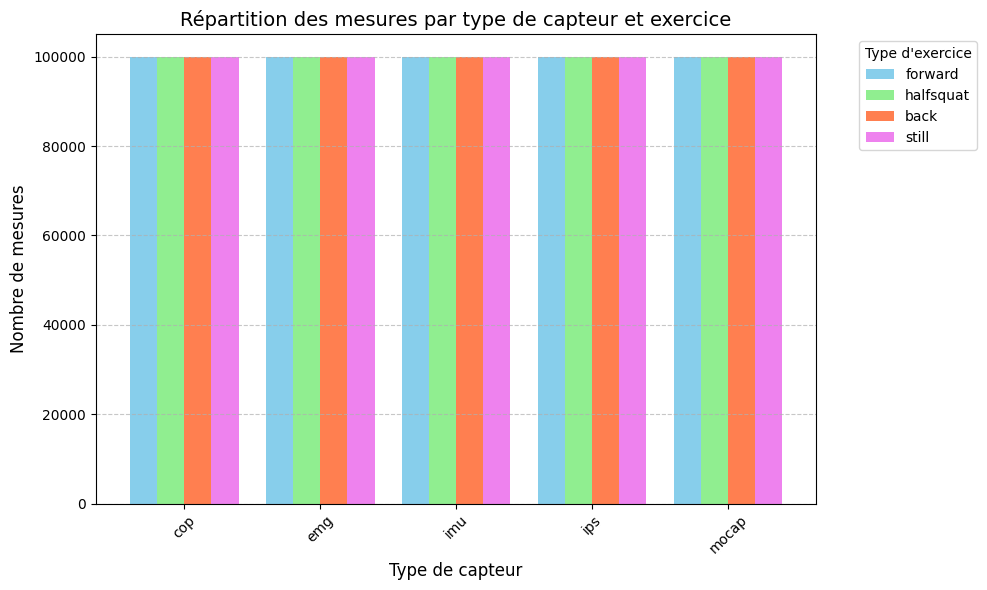

In [143]:
# Plot settings
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting grouped bars
number_of_measures.plot(kind='bar', ax=ax, width=0.8, color=['skyblue', 'lightgreen', 'coral', 'violet', 'gold'])

# Customize axes
ax.set_xlabel("Type de capteur", fontsize=12)
ax.set_ylabel("Nombre de mesures", fontsize=12)
ax.set_title("Répartition des mesures par type de capteur et exercice", fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.tick_params(axis='x', rotation=45)

# Add legend
ax.legend(title="Type d'exercice", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [146]:
LOGO_SPLIT_FILES_PATH = sorted(get_files_paths('logo_split'), key=extract_number_from_path)

In [147]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

sampling_strategy = {}
for exercice in EXERCICES_TYPE:
    sampling_strategy[exercice] = 100000  # Nombre cible d'échantillons pour chaque classe

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

for file_path in LOGO_SPLIT_FILES_PATH:
    df = pd.read_csv(file_path)

    df.dropna(inplace=True)
    # Séparation des caractéristiques et des labels
    X = df.drop(columns=['label','patient'])  # Caractéristiques
    y = df['label']  # Labels
    z = df['patient']
        
    # Vérification de la distribution des classes actuelles
    current_class_counts = y.value_counts()

    if(X.shape[0] != 400000):
        
        print(f"Before SMOTE or Under-Sampling to {file_path}")
        print(X.shape, y.shape)
        # Appliquer un RandomUnderSampler uniquement si une classe a plus d'échantillons que la cible
        if any(current_class_counts[exercice] > 100000 for exercice in EXERCICES_TYPE):
            print("Applying Random Under-Sampling due to over-represented classes")
            # Sous-échantillonnage : ne réduire qu'à la taille cible (pas plus)
            undersample_strategy = {exercice: min(current_class_counts[exercice], 100000) for exercice in EXERCICES_TYPE}
            under_sampler = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
            X_resampled, y_resampled = under_sampler.fit_resample(X, y)
        else:
            # Appliquer SMOTE pour équilibrer les classes (ajouter des échantillons)
            X_resampled, y_resampled = smote.fit_resample(X, y)

        print(f"After SMOTE or Under-Sampling to {file_path}")
        print(X_resampled.shape, y_resampled.shape)

        # Combinaison des caractéristiques et des labels dans un nouveau DataFrame
        """balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
        balanced_df['label'] = y_resampled
        balanced_df['patient'] = z"""
        balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                             pd.DataFrame({'label': y_resampled}), 
                             pd.DataFrame({'patient': z.iloc[:len(y_resampled)]})], axis=1)

        # Sauvegarder le DataFrame rééchantillonné dans un nouveau fichier CSV
        balanced_df.to_csv(file_path, index=False)
    else:
        print(f"Already balanced {file_path}")


Already balanced logo_split\cop.csv
Already balanced logo_split\emg.csv
Already balanced logo_split\imu.csv
Already balanced logo_split\ips.csv
Already balanced logo_split\mocap.csv


In [148]:
for exercice in EXERCICES_TYPE:
    for sensor in SENSORS_TYPE:
        data = pd.read_csv(f"logo_split/{sensor}.csv")
        number_of_measures.loc[sensor,exercice] = data[data['label'] == exercice].shape[0]
        
number_of_measures

,forward,halfsquat,back,still
cop,100000,100000,100000,100000
emg,100000,100000,100000,100000
imu,100000,100000,100000,100000
ips,100000,100000,100000,100000
mocap,100000,100000,100000,100000


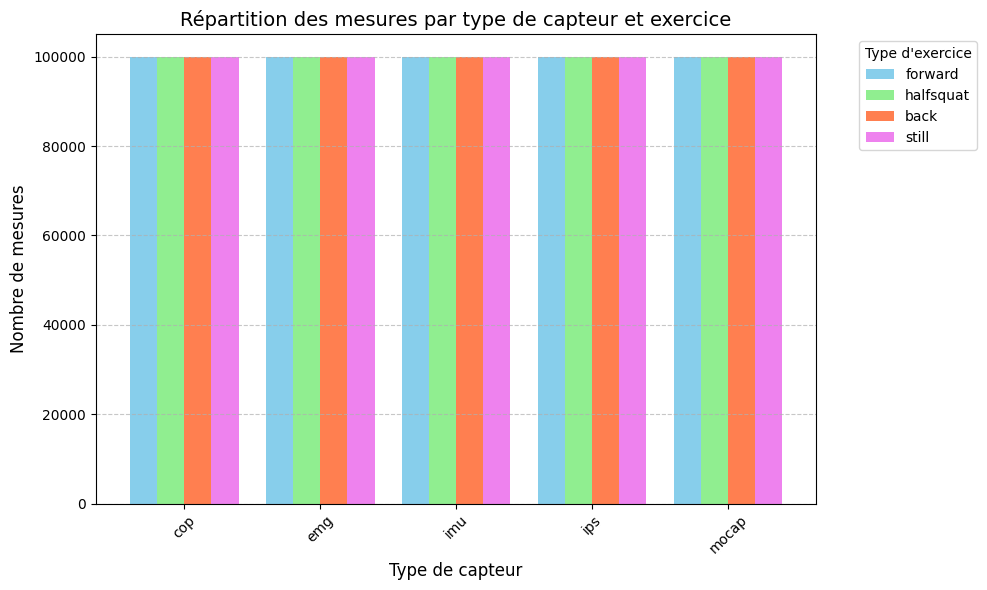

In [150]:
# Plot settings
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting grouped bars
number_of_measures.plot(kind='bar', ax=ax, width=0.8, color=['skyblue', 'lightgreen', 'coral', 'violet', 'gold'])

# Customize axes
ax.set_xlabel("Type de capteur", fontsize=12)
ax.set_ylabel("Nombre de mesures", fontsize=12)
ax.set_title("Répartition des mesures par type de capteur et exercice", fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.tick_params(axis='x', rotation=45)

# Add legend
ax.legend(title="Type d'exercice", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [151]:
combined_df = pd.DataFrame()
for sensor in SENSORS_TYPE:
    data = pd.read_csv(f"normal_split/{sensor}.csv")
    combined_df.drop(columns=['label'], inplace=True,errors='ignore')
    combined_df = pd.concat([combined_df, data], axis=1)

In [152]:
combined_df.head()

,L_force,R_force,L_cop_x,L_cop_y,R_cop_x,R_cop_y,L_cop_col,L_cop_row,R_cop_col,R_cop_row,...,L_LM_x,L_LM_y,L_LM_z,L_CAL_x,L_CAL_y,L_CAL_z,L_MH1_x,L_MH1_y,L_MH1_z,label
0,367.862947,386.250163,0.234623,0.322513,0.276306,-0.064774,6.20,15.00,6.59,14.01,...,0.171851,0.323907,0.099630,0.098099,0.257530,0.038906,0.378321,0.346032,0.043509,forward
1,367.304960,385.380230,0.234408,0.322406,0.276087,-0.064662,6.19,15.03,6.60,14.04,...,0.171848,0.323912,0.099630,0.098101,0.257531,0.038903,0.378319,0.346030,0.043509,forward
2,368.974528,387.120096,0.234187,0.322308,0.275852,-0.064574,6.20,15.06,6.60,14.07,...,0.171845,0.323917,0.099630,0.098103,0.257532,0.038900,0.378317,0.346027,0.043509,forward
3,368.974528,386.250163,0.233961,0.322200,0.275937,-0.064603,6.21,15.09,6.60,14.06,...,0.171842,0.323923,0.099629,0.098105,0.257533,0.038898,0.378315,0.346025,0.043508,forward
4,368.974528,386.250163,0.233738,0.322105,0.276169,-0.064702,6.21,15.12,6.60,14.03,...,0.171839,0.323928,0.099629,0.098106,0.257534,0.038895,0.378314,0.346023,0.043508,forward


In [153]:
# Paramètres de la fenêtre
window_size = 60  # Taille de la fenêtre (60 échantillons pour 1 seconde)
step_size = 60  # Pas de la fenêtre (60 échantillons pour pas de chevauchement)

# Segmenter les données en fenêtres
X, y = create_windows(combined_df, window_size, step_size)

# Affichage des dimensions des données segmentées
print(f'X shape: {X.shape}, y shape: {y.shape}')

X shape: (6666, 59, 840), y shape: (6666,)


In [154]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# Normalisation des données sur chaque fenêtre
scaler = StandardScaler()

# Appliquer la normalisation sur chaque fenêtre (chaque "fenêtre" dans X)
X_scaled = np.array([scaler.fit_transform(window) for window in X])

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# Encodage des labels en one-hot
y_encoded = to_categorical(label_encoder.fit_transform(y), num_classes=4)

# Diviser les données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')


X_train shape: (5332, 59, 840), X_test shape: (1334, 59, 840)


In [206]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Fonction pour créer le modèle CNN-LSTM
def create_cnn_lstm_model(input_shape, filters=32, kernel_size=3, lstm_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(Conv1D(filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, activation='relu', return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))  # 4 classes à prédire
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Encapsuler le modèle dans KerasClassifier pour l'utiliser avec GridSearchCV
model = KerasClassifier(build_fn=create_cnn_lstm_model, input_shape=X_train.shape[1:], epochs=10, batch_size=32, verbose=0)

# Définir la grille des hyperparamètres à tester
param_grid = {
    'batch_size': [16, 32],
    'epochs': [5, 10]
}

# Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Résultats de la recherche
print(f"Meilleurs paramètres: {grid_search.best_params_}")
print(f"Meilleur score: {grid_search.best_score_}")


C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model``

Meilleurs paramètres: {'batch_size': 16, 'epochs': 10}
Meilleur score: 0.9045403511392814


In [ ]:
# Créer le modèle CNN-LSTM
cnn_lstm_model = create_cnn_lstm_model(X_train.shape[1:3])

# Entraîner le modèle
history_cnn_lstm = cnn_lstm_model.fit(X_train, y_train, epochs=grid_search.best_params_['epochs'], batch_size=grid_search.best_params_['batch_size'], validation_data=(X_test, y_test))

# Évaluer les performances sur l'ensemble de test
score_cnn_lstm = cnn_lstm_model.evaluate(X_test, y_test)
print(f"Score du modèle CNN-LSTM : {score_cnn_lstm}")


C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5234 - loss: 1.1018 - val_accuracy: 0.8748 - val_loss: 0.3839
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8578 - loss: 0.4414 - val_accuracy: 0.8891 - val_loss: 0.3578
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8807 - loss: 0.3876 - val_accuracy: 0.9183 - val_loss: 0.2668
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9094 - loss: 0.2630 - val_accuracy: 0.9213 - val_loss: 0.2555
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9053 - loss: 0.2651 - val_accuracy: 0.9160 - val_loss: 0.2643
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9088 - loss: 0.2615 - val_accuracy: 0.9190 - val_loss: 0.2361
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9201 - loss: 0.2246 - val_accuracy: 0.6619 - val_loss: 0.7997
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7053 - loss: 0.7308 - val_accuracy: 0.

In [158]:
from sklearn.preprocessing import StandardScaler

# Paramètres de la fenêtre
window_size = 60  # Taille de la fenêtre (60 échantillons pour 1 seconde)
step_size = 60  # Pas de la fenêtre (60 échantillons pour pas de chevauchement)

X_ips, y = create_windows(pd.read_csv("normal_split/ips.csv"), window_size, step_size)
X_emg, y = create_windows(pd.read_csv("normal_split/emg.csv"), window_size, step_size)
X_imu, y = create_windows(pd.read_csv("normal_split/imu.csv"), window_size, step_size)
X_cop, y = create_windows(pd.read_csv("normal_split/cop.csv"), window_size, step_size)
X_mocap, y = create_windows(pd.read_csv("normal_split/mocap.csv"), window_size, step_size)

# Normalisation pour chaque modalité (EMG, IMU, IPS)
scaler = StandardScaler()

# Normaliser les données EMG et IMU sur chaque fenêtre (chaque "fenêtre" dans X_emg et X_imu)
X_emg_scaled = np.array([scaler.fit_transform(window) for window in X_emg])
X_imu_scaled = np.array([scaler.fit_transform(window) for window in X_imu])
X_ips_scaled = np.array([scaler.fit_transform(window) for window in X_ips])
X_cop_scaled = np.array([scaler.fit_transform(window) for window in X_cop])
X_mocap_scaled = np.array([scaler.fit_transform(window) for window in X_mocap])


In [159]:
label_encoder = LabelEncoder()
y_encoded = to_categorical(label_encoder.fit_transform(y), num_classes=4)

In [160]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test (80% - 20%)
X_emg_train, X_emg_test, X_imu_train, X_imu_test, X_cop_train,X_cop_test,X_mocap_train,X_mocap_test,X_ips_train, X_ips_test, y_train, y_test = train_test_split(
    X_emg_scaled, X_imu_scaled,X_cop_scaled,X_mocap_scaled, X_ips_scaled, y_encoded, test_size=0.2, random_state=42
)

In [ ]:
input_shapes = [
    X_emg_train.shape[1:3],
    X_imu_train.shape[1:3],
    X_ips_train.shape[1:3],
    X_cop_train.shape[1:3],
    X_mocap_train.shape[1:3],
]

print(input_shapes)

In [203]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Architecture CNN-LSTM multimodale
def create_cnn_lstm_multimodal_model(input_shapes):
    # Sous-modèle EMG (ici on suppose que c'est une séquence temporelle, donc on utilise un CNN-LSTM)
    emg_input = Input(shape=input_shapes[0], name='emg_input')
    emg_conv1D = Conv1D(32, kernel_size=3, activation='relu')(emg_input)
    emg_maxPooling1D = MaxPooling1D(pool_size=2)(emg_conv1D)
    emg_dropout = Dropout(0.2)(emg_maxPooling1D)
    emg_lstm = LSTM(64, activation='relu', return_sequences=False)(emg_dropout)
    emg_dense = Dropout(0.2)(emg_lstm)
    
    # Sous-modèle IMU (si c'est aussi une séquence temporelle, appliquer CNN-LSTM ici aussi)
    imu_input = Input(shape=input_shapes[1], name='imu_input')
    imu_conv1D = Conv1D(32, kernel_size=3, activation='relu')(imu_input)
    imu_maxPooling1D = MaxPooling1D(pool_size=2)(imu_conv1D)
    imu_dropout = Dropout(0.2)(imu_maxPooling1D)
    imu_lstm = LSTM(64, activation='relu', return_sequences=False)(imu_dropout)
    imu_dense = Dropout(0.2)(imu_lstm)

    # Sous-modèle IPS (données non séquentielles, on utilise des couches denses simples)
    ips_input = Input(shape=input_shapes[2], name='ips_input')
    ips_conv1D = Conv1D(32, kernel_size=3, activation='relu')(ips_input)
    ips_maxPooling1D = MaxPooling1D(pool_size=2)(ips_conv1D)
    ips_dropout = Dropout(0.2)(ips_maxPooling1D)
    ips_lstm = LSTM(64, activation='relu', return_sequences=False)(ips_dropout)
    ips_dense = Dropout(0.2)(ips_lstm)

    # Sous-modèle COP
    cop_input = Input(shape=input_shapes[3], name='cop_input')
    cop_conv1D = Conv1D(32, kernel_size=3, activation='relu')(cop_input)
    cop_maxPooling1D = MaxPooling1D(pool_size=2)(cop_conv1D)
    cop_dropout = Dropout(0.2)(cop_maxPooling1D)
    cop_lstm = LSTM(64, activation='relu', return_sequences=False)(cop_dropout)
    cop_dense = Dropout(0.2)(cop_lstm)

    # Sous-modèle MOCAP
    mocap_input = Input(shape=input_shapes[4], name='mocap_input')
    mocap_conv1D = Conv1D(32, kernel_size=3, activation='relu')(mocap_input)
    mocap_maxPooling1D = MaxPooling1D(pool_size=2)(mocap_conv1D)
    mocap_dropout = Dropout(0.2)(mocap_maxPooling1D)
    mocap_lstm = LSTM(64, activation='relu', return_sequences=False)(mocap_dropout)
    mocap_dense = Dropout(0.2)(mocap_lstm)

    # Fusion des sorties (EMG, IMU, IPS, COP, MOCAP)
    concatenated = Concatenate()([emg_dense, imu_dense, ips_dense, cop_dense, mocap_dense])

    # Couche dense après fusion
    dense = Dense(64, activation='relu')(concatenated)
    dense = Dropout(0.2)(dense)

    # Couche de sortie
    output = Dense(4, activation='softmax')(dense)  # 4 classes à prédire

    # Création du modèle final
    model = Model(inputs=[emg_input, imu_input, ips_input, cop_input, mocap_input], outputs=output)

    # Compilation du modèle
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [204]:
cnn_lstm_multimodal_model = create_cnn_lstm_multimodal_model(input_shapes)

In [207]:
# Entraîner le modèle
history_cnn_lstm_multimodal = cnn_lstm_model.fit(X_train, y_train, epochs=grid_search.best_params_['epochs'], batch_size=grid_search.best_params_['batch_size'], validation_data=(X_test, y_test))

# Évaluer les performances sur l'ensemble de test
score_cnn_lstm = cnn_lstm_model.evaluate(X_test, y_test)
print(f"Score du modèle CNN-LSTM : {score_cnn_lstm}")

Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8832 - loss: 0.3329 - val_accuracy: 0.9063 - val_loss: 0.2822
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9019 - loss: 0.2639 - val_accuracy: 0.9138 - val_loss: 0.2476
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9004 - loss: 0.2630 - val_accuracy: 0.9183 - val_loss: 0.2240
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9147 - loss: 0.2430 - val_accuracy: 0.9138 - val_loss: 0.2191
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9181 - loss: 0.2283 - val_accuracy: 0.9190 - val_loss: 0.2305
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9270 - loss: 0.1963 - val_accuracy: 0.9175 - val_loss: 0.2441
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9337 - loss: 0.1799 - val_accuracy: 0.9250 - val_loss: 0.2358
Epoch 8/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9324 - loss: 0.1852 - val_accuracy: 0.

In [ ]:
# Entraînement du modèle multimodal CNN-LSTM
history_cnn_lstm_multimodal = cnn_lstm_multimodal_model.fit(
    [X_emg_train, X_imu_train, X_ips_train,X_cop_train,X_mocap_train], y_train,
    batch_size=32,
    epochs=10,
    validation_data=([X_emg_test, X_imu_test, X_ips_test,X_cop_test,X_mocap_test], y_test)
)

Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9926 - loss: 0.0358 - val_accuracy: 0.9753 - val_loss: 0.0976
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9967 - loss: 0.0123 - val_accuracy: 0.9775 - val_loss: 0.1236
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9934 - loss: 0.0192 - val_accuracy: 0.9730 - val_loss: 0.1033
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9916 - loss: 0.0307 - val_accuracy: 0.9753 - val_loss: 0.0890
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9864 - loss: 0.0820 - val_accuracy: 0.9700 - val_loss: 0.0990
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9883 - loss: 0.0424 - val_accuracy: 0.9738 - val_loss: 0.1348
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9826 - loss: 0.0779 - val_accuracy: 0.9730 - val_loss: 0.0842
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9865 - loss: 0.0465 - val_accu

In [166]:
score_cnn_lstm_multimodal = cnn_lstm_multimodal_model.evaluate([X_emg_train, X_imu_train, X_ips_train,X_cop_train,X_mocap_train], y_train)
print(f"Score du modèle CNN-LSTM : {score_cnn_lstm_multimodal}")

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9984 - loss: 0.0059
Score du modèle CNN-LSTM : [0.005437111482024193, 0.9984996318817139]


In [163]:
# Afficher le résumé du modèle
cnn_lstm_multimodal_model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ emg_input           │ (None, 59, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ imu_input           │ (None, 59, 54)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ips_input           │ (None, 59, 682)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cop_input           │ (None, 59, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mocap_input         │ (None, 59, 78)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 57, 32)    │      1,568 │ emg_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 57, 32)    │      5,216 │ imu_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 57, 32)    │     65,504 │ ips_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 57, 32)    │        992 │ cop_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 57, 32)    │      7,520 │ mocap_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 28, 32)    │          0 │ conv1d_13[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_14    │ (None, 28, 32)    │          0 │ conv1d_14[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_15    │ (None, 28, 32)    │          0 │ conv1d_15[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 28, 32)    │          0 │ conv1d_16[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 28, 32)    │          0 │ conv1d_17[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 28, 32)    │          0 │ max_pooling1d_13… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 28, 32)    │          0 │ max_pooling1d_14… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 28, 32)    │          0 │ max_pooling1d_15… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 677,294 (2.58 MB)

 Trainable params: 225,764 (881.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 451,530 (1.72 MB)

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Rapport de Classification - CNN-LSTM :
               precision    recall  f1-score   support

        back       0.91      0.85      0.88       326
     forward       0.91      0.92      0.91       345
   halfsquat       0.83      0.89      0.86       331
       still       0.96      0.94      0.95       332

    accuracy                           0.90      1334
   macro avg       0.90      0.90      0.90      1334
weighted avg       0.90      0.90      0.90      1334



C:\Users\floda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['emg_input', 'imu_input', 'ips_input', 'cop_input', 'mocap_input']. Received: the structure of inputs=('*', '*', '*', '*', '*')
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Rapport de Classification - Multimodal CNN-LSTM :
               precision    recall  f1-score   support

        back       0.99      0.94      0.97       326
     forward       0.99      0.98      0.98       345
   halfsquat       0.93      0.99      0.96       331
       still       1.00      0.99      1.00       332

    accuracy                           0.98      1334
   macro avg       0.98      0.98      0.98      1334
weighted avg       0.98      0.98      0.98      1334



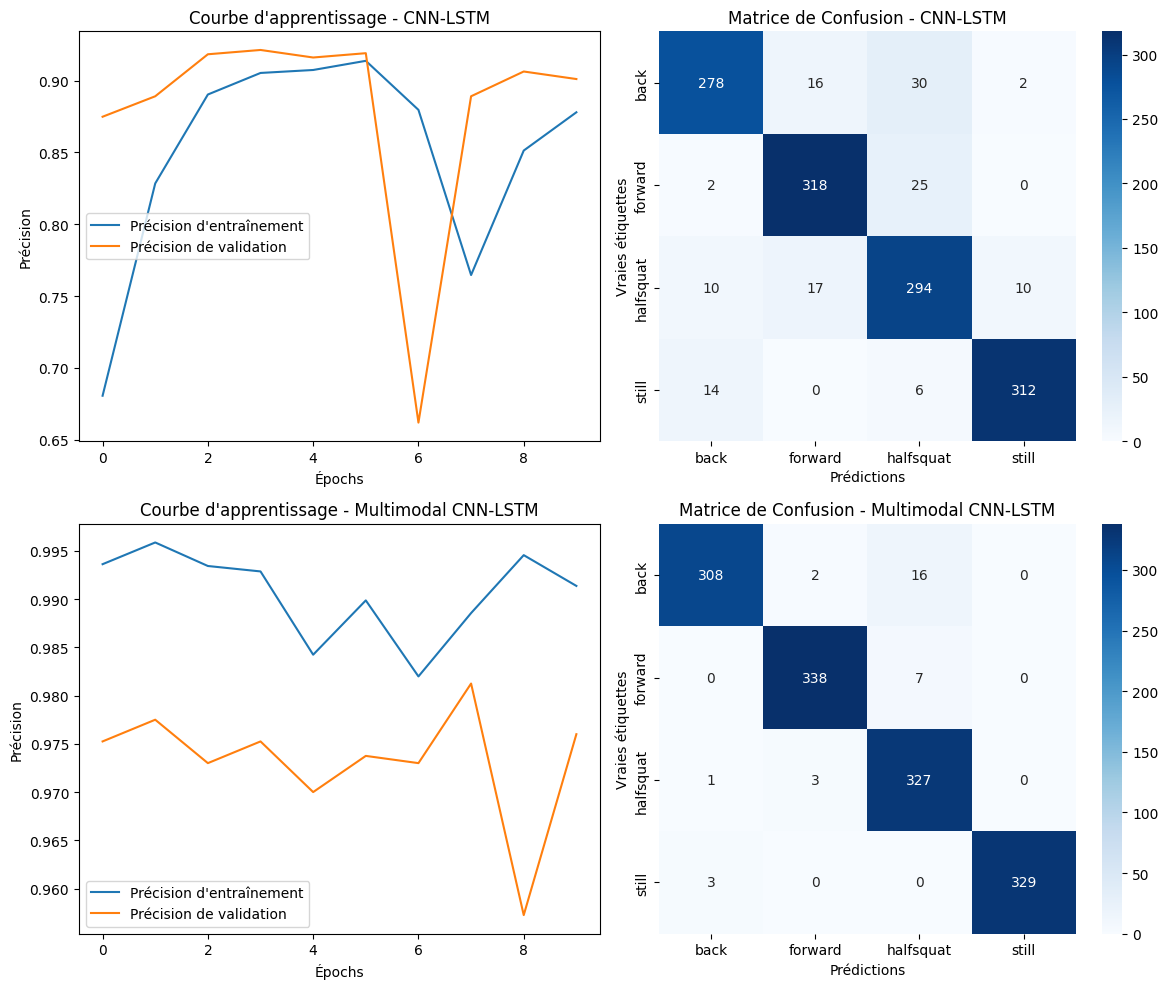

In [168]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# ------------------------ Code for CNN-LSTM ------------------------
# Prédictions sur l'ensemble de test pour CNN-LSTM
y_pred_cnn_lstm = np.argmax(cnn_lstm_model.predict(X_test), axis=-1)

# Si y_test est one-hot encodé, convertir y_test en labels d'indices entiers
y_test_labels = np.argmax(y_test, axis=-1)

# Générer un rapport de classification pour CNN-LSTM
report_cnn_lstm = classification_report(y_test_labels, y_pred_cnn_lstm, target_names=label_encoder.classes_)
print("Rapport de Classification - CNN-LSTM :\n", report_cnn_lstm)

# Matrice de confusion pour CNN-LSTM
conf_matrix_cnn_lstm = confusion_matrix(y_test_labels, y_pred_cnn_lstm)

# ------------------------ Code for Multimodal CNN-LSTM ------------------------
# Prédictions sur l'ensemble de test pour le modèle multimodal CNN-LSTM
predictions_multimodal = cnn_lstm_multimodal_model.predict([X_emg_test, X_imu_test, X_ips_test, X_cop_test, X_mocap_test])

y_pred_multimodal = np.argmax(predictions_multimodal, axis=-1)

# Générer un rapport de classification pour le modèle multimodal CNN-LSTM
report_multimodal = classification_report(y_test_labels, y_pred_multimodal, target_names=label_encoder.classes_)
print("Rapport de Classification - Multimodal CNN-LSTM :\n", report_multimodal)

# Matrice de confusion pour le modèle multimodal CNN-LSTM
conf_matrix_multimodal = confusion_matrix(y_test_labels, y_pred_multimodal)

# ------------------------ Plotting Results ------------------------

# Courbes d'apprentissage pour les deux modèles
plt.figure(figsize=(12, 10))

# Courbes d'apprentissage - CNN-LSTM
plt.subplot(2, 2, 1)
plt.plot(history_cnn_lstm.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn_lstm.history['val_accuracy'], label='Précision de validation')
plt.title('Courbe d\'apprentissage - CNN-LSTM')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

# Matrice de confusion - CNN-LSTM
plt.subplot(2, 2, 2)
sns.heatmap(conf_matrix_cnn_lstm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de Confusion - CNN-LSTM')

# Courbes d'apprentissage - Multimodal CNN-LSTM
plt.subplot(2, 2, 3)
plt.plot(history_cnn_lstm_multimodal.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn_lstm_multimodal.history['val_accuracy'], label='Précision de validation')
plt.title('Courbe d\'apprentissage - Multimodal CNN-LSTM')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

# Matrice de confusion - Multimodal CNN-LSTM
plt.subplot(2, 2, 4)
sns.heatmap(conf_matrix_multimodal, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de Confusion - Multimodal CNN-LSTM')

# Ajustement pour éviter le chevauchement des titres et des étiquettes
plt.tight_layout()
plt.show()
